## Generative Adversarial Networks - Physics Informed - Buckley Leverett Equation

### Imports and Configs

In [1]:
import time
import os
import scipy.io
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from gan_pde import*
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('text', usetex=False)
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' 

seed  = 340
tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Load Data

In [2]:
path_lib = os.path.dirname(os.getcwd())
path_resources = os.path.join(path_lib, 'resources')
path_data = os.path.join(path_resources, 'data')
path_models = os.path.join(path_resources, 'models')

# filename = 'Buckley_Gravity_Swc0.2_Sor_0_M_5_theta_90.mat'#'Buckley_Swc0.1_Sor_0_M_10.mat'
filename = 'Buckley_Swc0.1_Sor_0_M_10.mat'
path_file = os.path.join(path_data, filename)
data = scipy.io.loadmat(path_file)

### Deep Learning Params

In [3]:
n_u = 200
n_boundary_t_0 = 50 #only shock is at 0 (for buckley gravity)
n_boundary_t_1_x_inf_m4 = 1
n_boundary_t_1_x_sup_11 = 1

latent_var_nb = 1

gen_layer_lst = [50, 50, 50, 50, 1]
pos_layer_lst = [50, 50, 50, 50, 1]
dis_layer_lst = [50, 50, 50, 1]

gen_activation_lst = [tf.nn.tanh for i in range(len(gen_layer_lst)-1)]
pos_activation_lst = [tf.nn.tanh for i in range(len(pos_layer_lst)-1)]
dis_activation_lst = [tf.nn.tanh for i in range(len(dis_layer_lst)-1)]
gen_activation_lst.append(None)
pos_activation_lst.append(None)
dis_activation_lst.append(None)

w_pde_loss = 1.0
w_posterior_loss = 1.5

learning_rate = 0.00005
batch_size = 150
dis_steps_nb = 3
gen_steps_nb = 6
iter_nb = 50000

In [4]:
df_data[(np.abs(df_data.t - 1.0) <= 1e-6) & (df_data.x < -4.8)]

NameError: name 'df_data' is not defined

In [5]:
df_data[(np.abs(df_data.t - 1.0) <= 1e-6) & (df_data.x > 11.9)]

NameError: name 'df_data' is not defined

### Prepare Data for Training

In [10]:
t_data = data['t'].flatten()[:, None]
x_data = data['x'].flatten()[:, None]
u_actual = np.real(data['usol']).T
x_mesh, t_mesh = np.meshgrid(x_data, t_data)


data_dict = dict(x=x_mesh.flatten(), t=t_mesh.flatten(), u=u_actual.flatten())
df_data = pd.DataFrame(data_dict)

idx_train = pd.Index(np.random.choice(len(df_data), n_u, replace=False))
idx_boundary_t_0 = pd.Index(np.random.choice(df_data[(df_data.t <= 1e-6) | (df_data.x == 1)].index, n_boundary_t_0, replace=False))
# idx_boundary_t_0 = pd.Index(np.random.choice(df_data[(df_data.t <= 1e-6) & (df_data.x < 0.0)].index, n_boundary_t_0, replace=False))
idx_boundary_t_1_x_inf_m4 = pd.Index(np.random.choice(df_data[(np.abs(df_data.t - 1.0) <= 1e-6) & (df_data.x < -4.8)].index, n_boundary_t_1_x_inf_m4, replace=False))
idx_boundary_t_1_x_sup_11 = pd.Index(np.random.choice(df_data[(np.abs(df_data.t - 1.0) <= 1e-6) & (df_data.x > 11.9)].index, n_boundary_t_1_x_sup_11, replace=False))
idx_train = idx_train.append((idx_boundary_t_0))
idx_train = idx_train.append((idx_boundary_t_1_x_inf_m4))
idx_train = idx_train.append((idx_boundary_t_1_x_sup_11))

idx_test = df_data.index.difference(idx_train)

u_train = df_data.u[idx_train].values[:,None]
x_train = df_data.x[idx_train].values[:,None]
t_train = df_data.t[idx_train].values[:,None]

u_test = df_data.u[idx_test].values[:,None]
x_test = df_data.x[idx_test].values[:,None]
t_test = df_data.t[idx_test].values[:,None]

ValueError: a must be non-empty

### GAN Training

Iter: 0,  discriminator: 1.4443,  generator: 0.2222,  entropy: -0.1219,  posterior: 0.3361,  pde: 0.0080


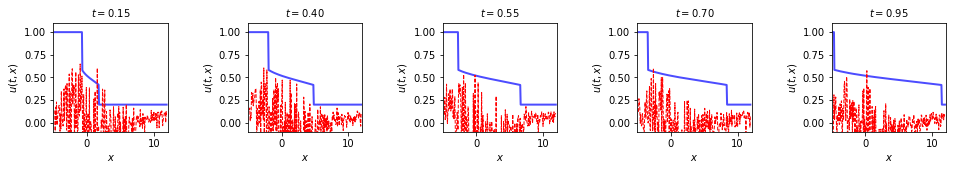

Iter: 500,  discriminator: 1.3827,  generator: -0.0488,  entropy: -0.0500,  posterior: 0.0003,  pde: 0.0009
Iter: 1000,  discriminator: 1.3838,  generator: -0.0341,  entropy: -0.0346,  posterior: 0.0001,  pde: 0.0005
Iter: 1500,  discriminator: 1.3880,  generator: -0.0042,  entropy: -0.0057,  posterior: 0.0000,  pde: 0.0015
Iter: 2000,  discriminator: 1.3768,  generator: -0.0105,  entropy: -0.0113,  posterior: 0.0000,  pde: 0.0008


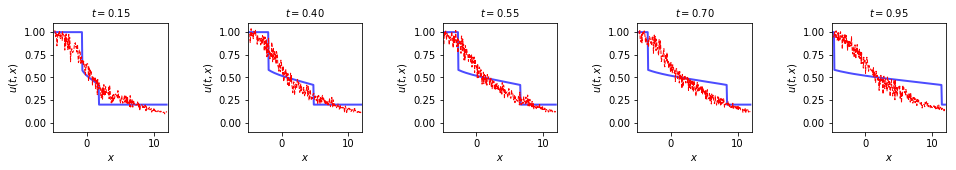

Iter: 2500,  discriminator: 1.3705,  generator: 0.0332,  entropy: 0.0210,  posterior: 0.0000,  pde: 0.0122
Iter: 3000,  discriminator: 1.3681,  generator: 0.0362,  entropy: 0.0019,  posterior: 0.0000,  pde: 0.0343
Iter: 3500,  discriminator: 1.3819,  generator: 0.0575,  entropy: -0.0087,  posterior: 0.0000,  pde: 0.0662
Iter: 4000,  discriminator: 1.3829,  generator: 0.0507,  entropy: 0.0083,  posterior: 0.0000,  pde: 0.0424


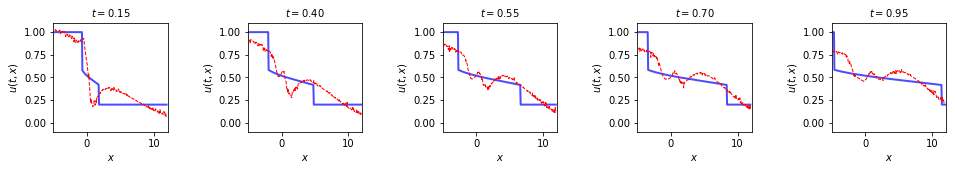

Iter: 4500,  discriminator: 1.3790,  generator: 0.0088,  entropy: -0.0401,  posterior: 0.0000,  pde: 0.0489
Iter: 5000,  discriminator: 1.3630,  generator: 0.0885,  entropy: 0.0471,  posterior: 0.0000,  pde: 0.0414
Iter: 5500,  discriminator: 1.3516,  generator: 0.1029,  entropy: 0.0623,  posterior: 0.0000,  pde: 0.0407
Iter: 6000,  discriminator: 1.3707,  generator: 0.0879,  entropy: 0.0157,  posterior: 0.0000,  pde: 0.0723


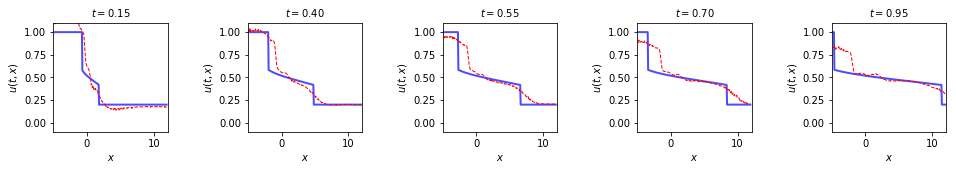

Iter: 6500,  discriminator: 1.3723,  generator: 0.0193,  entropy: -0.0369,  posterior: 0.0000,  pde: 0.0562
Iter: 7000,  discriminator: 1.3614,  generator: 0.0832,  entropy: 0.0206,  posterior: 0.0000,  pde: 0.0626
Iter: 7500,  discriminator: 1.3585,  generator: 0.0659,  entropy: 0.0489,  posterior: 0.0000,  pde: 0.0170
Iter: 8000,  discriminator: 1.3473,  generator: 0.0840,  entropy: 0.0602,  posterior: 0.0000,  pde: 0.0238


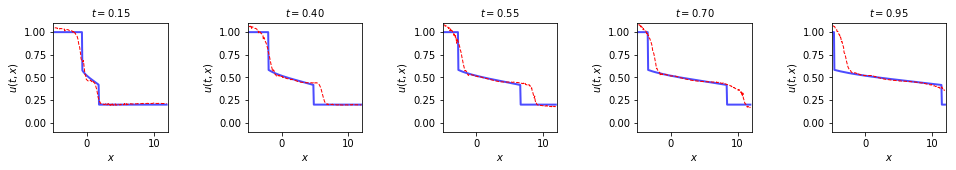

Iter: 8500,  discriminator: 1.3227,  generator: 0.1290,  entropy: 0.1176,  posterior: 0.0000,  pde: 0.0114
Iter: 9000,  discriminator: 1.3410,  generator: 0.1043,  entropy: 0.0954,  posterior: 0.0000,  pde: 0.0089
Iter: 9500,  discriminator: 1.3601,  generator: 0.0519,  entropy: 0.0482,  posterior: 0.0000,  pde: 0.0038
Iter: 10000,  discriminator: 1.3314,  generator: 0.1444,  entropy: 0.1400,  posterior: 0.0000,  pde: 0.0043


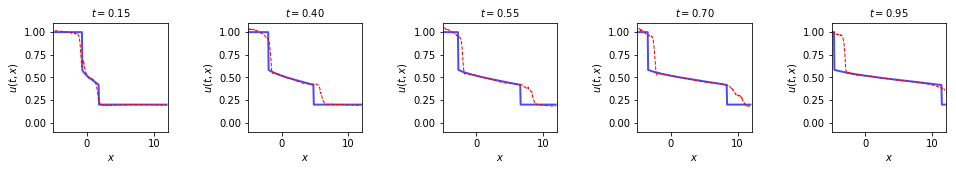

Iter: 10500,  discriminator: 1.3356,  generator: 0.1088,  entropy: 0.1031,  posterior: 0.0000,  pde: 0.0057
Iter: 11000,  discriminator: 1.3251,  generator: 0.1340,  entropy: 0.1299,  posterior: 0.0000,  pde: 0.0042
Iter: 11500,  discriminator: 1.3347,  generator: 0.1222,  entropy: 0.1194,  posterior: 0.0000,  pde: 0.0027
Iter: 12000,  discriminator: 1.3659,  generator: 0.0365,  entropy: 0.0303,  posterior: 0.0000,  pde: 0.0062


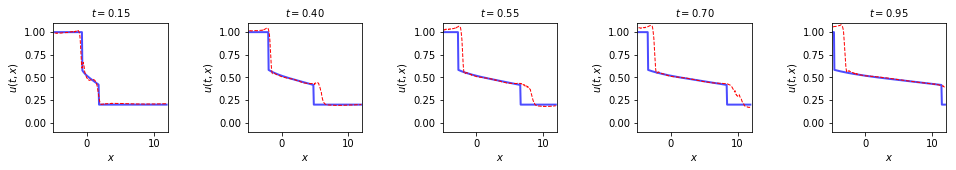

Iter: 12500,  discriminator: 1.3635,  generator: 0.0649,  entropy: 0.0606,  posterior: 0.0000,  pde: 0.0044
Iter: 13000,  discriminator: 1.3109,  generator: 0.2242,  entropy: 0.2222,  posterior: 0.0000,  pde: 0.0021
Iter: 13500,  discriminator: 1.3569,  generator: 0.0810,  entropy: 0.0786,  posterior: 0.0000,  pde: 0.0024
Iter: 14000,  discriminator: 1.3130,  generator: 0.0171,  entropy: -0.0207,  posterior: 0.0000,  pde: 0.0378


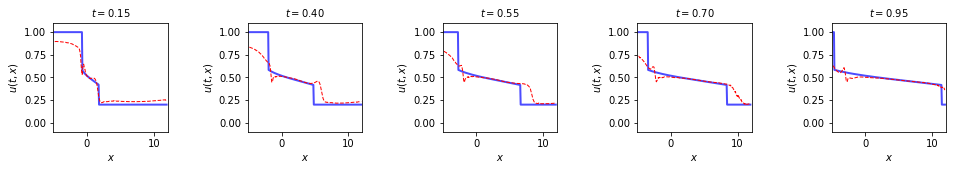

Iter: 14500,  discriminator: 1.3201,  generator: 0.1732,  entropy: 0.1676,  posterior: 0.0000,  pde: 0.0056
Iter: 15000,  discriminator: 1.3312,  generator: 0.1659,  entropy: 0.1619,  posterior: 0.0000,  pde: 0.0040
Iter: 15500,  discriminator: 1.3049,  generator: 0.2408,  entropy: 0.2367,  posterior: 0.0000,  pde: 0.0041
Iter: 16000,  discriminator: 1.3134,  generator: 0.2292,  entropy: 0.2248,  posterior: 0.0000,  pde: 0.0043


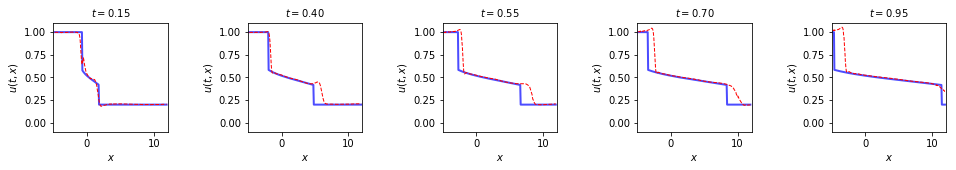

Iter: 16500,  discriminator: 1.3509,  generator: 0.1008,  entropy: 0.0948,  posterior: 0.0000,  pde: 0.0061
Iter: 17000,  discriminator: 1.3179,  generator: 0.2186,  entropy: 0.2150,  posterior: 0.0000,  pde: 0.0036
Iter: 17500,  discriminator: 1.3260,  generator: 0.2186,  entropy: 0.2072,  posterior: 0.0000,  pde: 0.0114
Iter: 18000,  discriminator: 1.3127,  generator: 0.2779,  entropy: 0.2697,  posterior: 0.0000,  pde: 0.0082


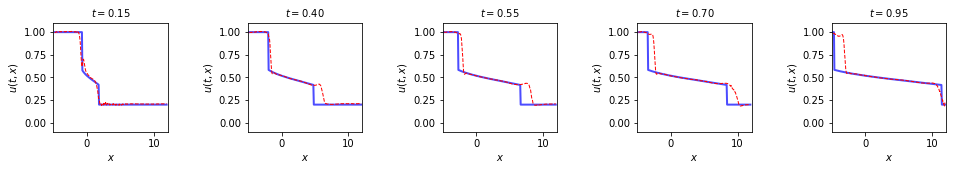

Iter: 18500,  discriminator: 1.3599,  generator: 0.1216,  entropy: 0.1089,  posterior: 0.0000,  pde: 0.0127
Iter: 19000,  discriminator: 1.3270,  generator: 0.2223,  entropy: 0.2180,  posterior: 0.0000,  pde: 0.0043
Iter: 19500,  discriminator: 1.3226,  generator: 0.2232,  entropy: 0.2153,  posterior: 0.0000,  pde: 0.0079
Iter: 20000,  discriminator: 1.3355,  generator: 0.2118,  entropy: 0.2078,  posterior: 0.0000,  pde: 0.0040


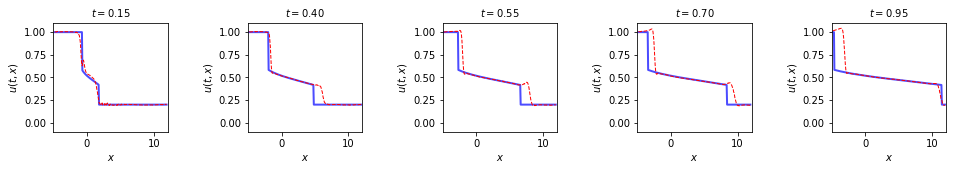

Iter: 20500,  discriminator: 1.3345,  generator: 0.2170,  entropy: 0.2147,  posterior: 0.0000,  pde: 0.0023
Iter: 21000,  discriminator: 1.3184,  generator: 0.2854,  entropy: 0.2834,  posterior: 0.0000,  pde: 0.0020
Iter: 21500,  discriminator: 1.3343,  generator: 0.1996,  entropy: 0.1961,  posterior: 0.0000,  pde: 0.0035
Iter: 22000,  discriminator: 1.2810,  generator: 0.2970,  entropy: 0.2010,  posterior: 0.0000,  pde: 0.0960


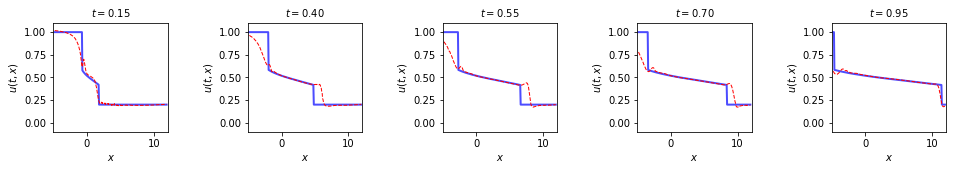

Iter: 22500,  discriminator: 1.3248,  generator: 0.2243,  entropy: 0.1141,  posterior: 0.0000,  pde: 0.1103
Iter: 23000,  discriminator: 1.3433,  generator: 0.1502,  entropy: 0.1197,  posterior: 0.0000,  pde: 0.0305
Iter: 23500,  discriminator: 1.3309,  generator: 0.1499,  entropy: 0.1452,  posterior: 0.0000,  pde: 0.0047
Iter: 24000,  discriminator: 1.3354,  generator: 0.1521,  entropy: 0.1500,  posterior: 0.0000,  pde: 0.0021


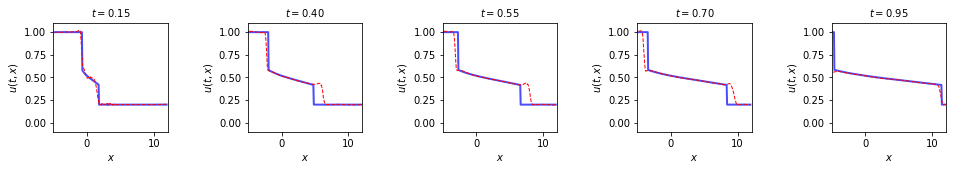

Iter: 24500,  discriminator: 1.3282,  generator: 0.1653,  entropy: 0.1627,  posterior: 0.0000,  pde: 0.0026
Iter: 25000,  discriminator: 1.3525,  generator: 0.0838,  entropy: 0.0813,  posterior: 0.0000,  pde: 0.0025
Iter: 25500,  discriminator: 1.3530,  generator: 0.0951,  entropy: 0.0932,  posterior: 0.0000,  pde: 0.0019
Iter: 26000,  discriminator: 1.3341,  generator: 0.1440,  entropy: 0.1413,  posterior: 0.0000,  pde: 0.0026


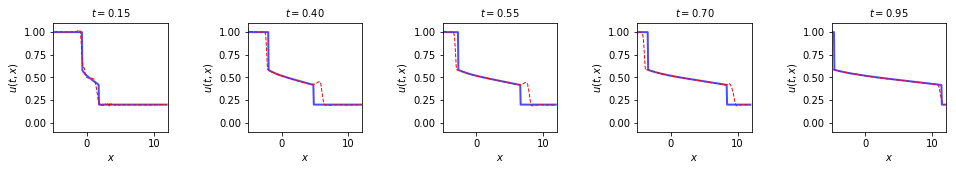

Iter: 26500,  discriminator: 1.3350,  generator: 0.1449,  entropy: 0.1429,  posterior: 0.0000,  pde: 0.0020
Iter: 27000,  discriminator: 1.3249,  generator: 0.2252,  entropy: 0.2076,  posterior: 0.0000,  pde: 0.0176
Iter: 27500,  discriminator: 1.3265,  generator: 0.2088,  entropy: 0.1816,  posterior: 0.0000,  pde: 0.0271
Iter: 28000,  discriminator: 1.3345,  generator: 0.1761,  entropy: 0.1655,  posterior: 0.0000,  pde: 0.0106


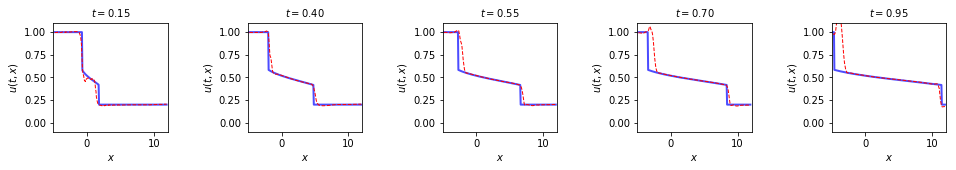

Iter: 28500,  discriminator: 1.3266,  generator: 0.2293,  entropy: 0.2210,  posterior: 0.0000,  pde: 0.0083
Iter: 29000,  discriminator: 1.3247,  generator: 0.2329,  entropy: 0.2283,  posterior: 0.0000,  pde: 0.0046
Iter: 29500,  discriminator: 1.3344,  generator: 0.1954,  entropy: 0.1927,  posterior: 0.0000,  pde: 0.0027
Iter: 30000,  discriminator: 1.3409,  generator: 0.1848,  entropy: 0.1817,  posterior: 0.0000,  pde: 0.0031


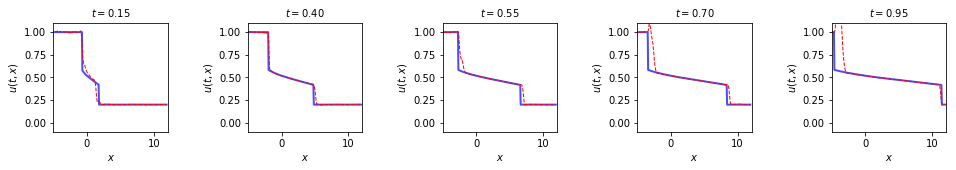

Iter: 30500,  discriminator: 1.3400,  generator: 0.1873,  entropy: 0.1844,  posterior: 0.0000,  pde: 0.0029
Iter: 31000,  discriminator: 1.3358,  generator: 0.2115,  entropy: 0.2048,  posterior: 0.0000,  pde: 0.0067
Iter: 31500,  discriminator: 1.3681,  generator: 0.0816,  entropy: 0.0786,  posterior: 0.0000,  pde: 0.0030
Iter: 32000,  discriminator: 1.3427,  generator: 0.1681,  entropy: 0.1632,  posterior: 0.0000,  pde: 0.0048


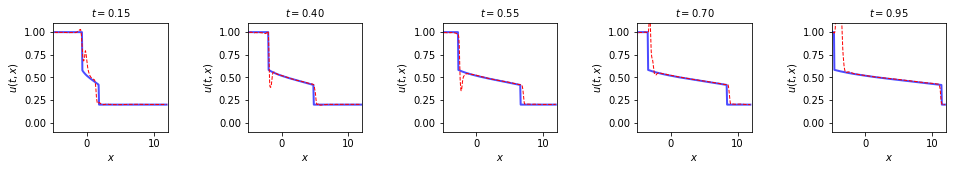

Iter: 32500,  discriminator: 1.3425,  generator: 0.2083,  entropy: 0.2039,  posterior: 0.0000,  pde: 0.0044
Iter: 33000,  discriminator: 1.3485,  generator: 0.1865,  entropy: 0.1829,  posterior: 0.0000,  pde: 0.0036
Iter: 33500,  discriminator: 1.3417,  generator: 0.1941,  entropy: 0.1893,  posterior: 0.0000,  pde: 0.0048
Iter: 34000,  discriminator: 1.3411,  generator: 0.2241,  entropy: 0.2213,  posterior: 0.0000,  pde: 0.0028


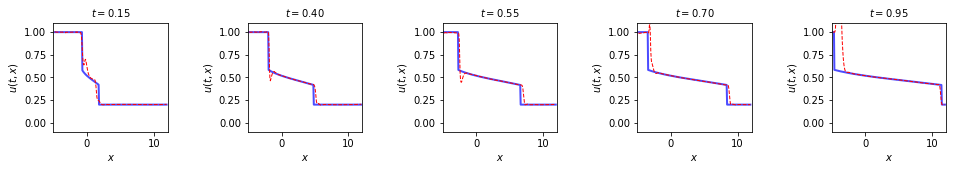

Iter: 34500,  discriminator: 1.3510,  generator: 0.1587,  entropy: 0.1560,  posterior: 0.0000,  pde: 0.0027
Iter: 35000,  discriminator: 1.3589,  generator: 0.1679,  entropy: 0.1658,  posterior: 0.0000,  pde: 0.0021
Iter: 35500,  discriminator: 1.3611,  generator: 0.1373,  entropy: 0.1350,  posterior: 0.0000,  pde: 0.0023
Iter: 36000,  discriminator: 1.3511,  generator: 0.1548,  entropy: 0.1516,  posterior: 0.0000,  pde: 0.0032


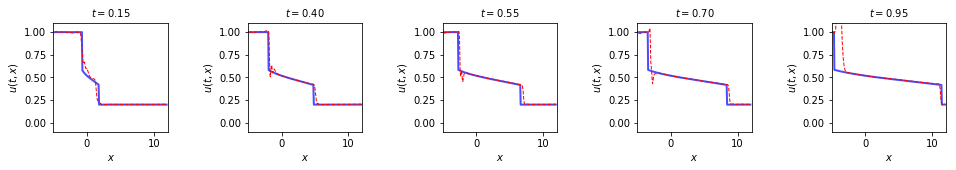

Iter: 36500,  discriminator: 1.3405,  generator: 0.2188,  entropy: 0.2146,  posterior: 0.0000,  pde: 0.0041
Iter: 37000,  discriminator: 1.3501,  generator: 0.1830,  entropy: 0.1810,  posterior: 0.0000,  pde: 0.0020
Iter: 37500,  discriminator: 1.3681,  generator: 0.1134,  entropy: 0.1110,  posterior: 0.0000,  pde: 0.0025
Iter: 38000,  discriminator: 1.3416,  generator: 0.2325,  entropy: 0.2299,  posterior: 0.0000,  pde: 0.0026


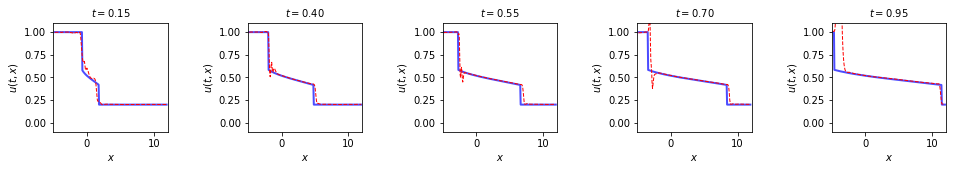

Iter: 38500,  discriminator: 1.3502,  generator: 0.1710,  entropy: 0.1644,  posterior: 0.0000,  pde: 0.0066
Iter: 39000,  discriminator: 1.3404,  generator: 0.2146,  entropy: 0.2123,  posterior: 0.0000,  pde: 0.0023
Iter: 39500,  discriminator: 1.3485,  generator: 0.2071,  entropy: 0.2002,  posterior: 0.0000,  pde: 0.0069
Iter: 40000,  discriminator: 1.3678,  generator: 0.0840,  entropy: 0.0820,  posterior: 0.0000,  pde: 0.0020


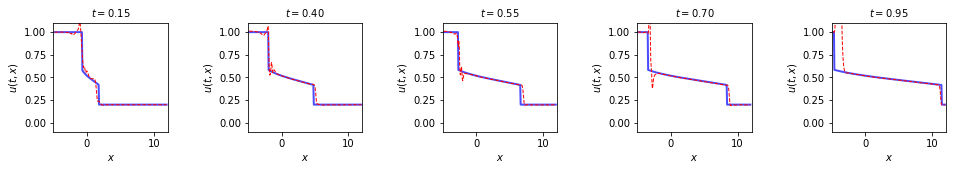

Iter: 40500,  discriminator: 1.3590,  generator: 0.1513,  entropy: 0.1467,  posterior: 0.0000,  pde: 0.0046
Iter: 41000,  discriminator: 1.3595,  generator: 0.1205,  entropy: 0.1139,  posterior: 0.0000,  pde: 0.0067
Iter: 41500,  discriminator: 1.3486,  generator: 0.1637,  entropy: 0.1611,  posterior: 0.0000,  pde: 0.0026
Iter: 42000,  discriminator: 1.3505,  generator: 0.1868,  entropy: 0.1849,  posterior: 0.0000,  pde: 0.0020


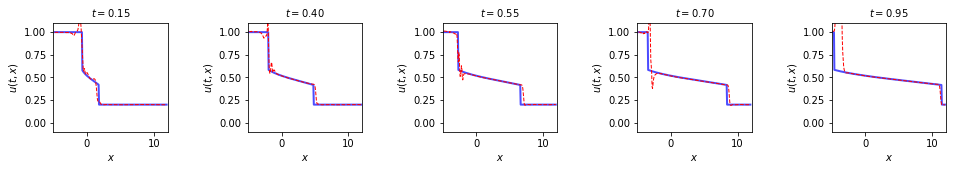

KeyboardInterrupt: 

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 1], name='x')
t = tf.placeholder(tf.float32, [None, 1], name='t')

with tf.variable_scope('generator'):
#     nu = tf.get_variable(name="nu", dtype=tf.float32, initializer=0.1)
    u_sample = tf.placeholder(tf.float32, [None, latent_var_nb], name='u_sample')
    mlp_config_generator = MLPConfig(layer_size_lst=gen_layer_lst,
                                     activation_lst=gen_activation_lst,
                                     main_name='generator')
    net_pde = create_mlp(tf.concat([x, t, u_sample], 1), mlp_config_generator)
    gen_pde = tf.concat([x, t, net_pde], axis=1, name='gen_pde')
    mlp_config_posterior = MLPConfig(layer_size_lst=pos_layer_lst, 
                                   activation_lst=pos_activation_lst, 
                                   main_name='posterior')
    logits_posterior = create_mlp(gen_pde, mlp_config_posterior)
    net_pde_residuals = net_pde_res_buckley_simple(net_pde, x, t)
    
    
with tf.variable_scope('discriminator') as scope:
    u_real = tf.placeholder(tf.float32, [None, 1])
    mlp_config_discriminator = MLPConfig(layer_size_lst=dis_layer_lst, 
                                         activation_lst=dis_activation_lst, 
                                         main_name='discriminator')
    logits_real = create_mlp(tf.concat([x, t, u_real], 1), mlp_config_discriminator)
    scope.reuse_variables()
    logits_fake = create_mlp(gen_pde, mlp_config_discriminator)

dis_loss = discriminator_loss(logits_real, logits_fake)
gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde = generator_loss(logits_fake, logits_posterior, net_pde_residuals, w_posterior_loss, w_pde_loss)

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator")
dis_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="discriminator")
gen_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(gen_loss, var_list=gen_vars)
dis_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(dis_loss, var_list=dis_vars)

init = tf.global_variables_initializer()
model_saver = tf.train.Saver()

with tf.Session() as sess:        
    sess.run(init)
    for i in range(iter_nb):
        idx_batch = np.random.choice(u_train.shape[0], batch_size, replace=False)   
        u_real_batch = u_train[idx_batch, :]
        u_sample_batch = np.random.normal(size=(u_real_batch.shape[0], latent_var_nb))
        x_batch = x_train[idx_batch, :]
        t_batch = t_train[idx_batch, :]
        for _ in range(dis_steps_nb):
            run_lst = [dis_minimize_step, dis_loss]
            feed_dict = {u_real: u_real_batch, u_sample: u_sample_batch, x: x_batch, t: t_batch}
            _, d_loss = sess.run(run_lst, feed_dict=feed_dict)

        for _ in range(gen_steps_nb):
            run_lst = [gen_minimize_step, gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde]
            feed_dict = feed_dict={u_sample: u_sample_batch,  x: x_batch, t: t_batch}
            _, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde = sess.run(run_lst, feed_dict=feed_dict)
            
        if i==0:
            loss_array = np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])
        if i % 500 == 0:
            str_out = "Iter: %d,  discriminator: %.4f,  generator: %.4f,  entropy: %.4f,  posterior: %.4f,  pde: %.4f"
            print(str_out % (i, d_loss, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde))
            loss_array = np.vstack((loss_array, np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])))

        if i % 2000 == 0:
            u_test_sample = np.random.normal(size=(u_test.shape[0], latent_var_nb))
            x_gen = sess.run(gen_pde, feed_dict={u_sample: u_test_sample, x: x_test, t: t_test})
            u_pred = griddata(df_data.loc[idx_test,['x', 't']], x_gen[:,2].flatten(), (x_mesh, t_mesh), method='cubic')

            cut_lst = [15, 40, 55, 70, 95]
            fig = plt.figure(figsize=(16,2))
            ax = fig.add_subplot(111)
            ax.axis('off')
            plot_nb = len(cut_lst)
            gs0 = gridspec.GridSpec(1, plot_nb, wspace=0.7)
            for j in range(plot_nb):
                plot_cut_test(grid_spec=gs0[0,j], x=x_data, actual=u_actual, pred=u_pred, cut=cut_lst[j], x_lim=[-5.0,12.1], y_lim=[-0.1,1.1])

#             plt.savefig('figures/buckley/diff{0:.0f}.png'.format(i))
            plt.show()
    model_saver.save(sess, os.path.join(path_models, "gan_buckley_s.ckpt"))

### 3D Actual vs Predicted 

In [ ]:
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

# Make plotly work with Jupyter notebook
init_notebook_mode()

pred = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = u_pred.flatten(),
    marker = go.Marker(color='red', size=1.5),
    mode = 'markers'
)

actual = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = df_data.u,
    marker = go.Marker(color='blue', size=1.5),
    mode = 'markers'
)

data = go.Data([pred, actual])

iplot(data)

### Loss Functions

In [ ]:
df_loss = pd.DataFrame(loss_array, columns=['iteration', 'discriminator', 'generator', 'entropy', 'posterior', 'pde'])
# df.plot(x=df.iteration, y=df.columns[1:], figsize=(17,8), fontsize=12)
df_loss.iteration = df_loss.iteration.astype(int)
df_loss.set_index(df_loss.iteration, inplace=True)
df_loss.drop(['iteration'], axis=1, inplace=True)
df_loss.plot(figsize=(17,8), fontsize=12)